Copyright (c) MONAI Consortium  
Licensed under the Apache License, Version 2.0 (the "License");  
you may not use this file except in compliance with the License.  
You may obtain a copy of the License at  
&nbsp;&nbsp;&nbsp;&nbsp;http://www.apache.org/licenses/LICENSE-2.0  
Unless required by applicable law or agreed to in writing, software  
distributed under the License is distributed on an "AS IS" BASIS,  
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  
See the License for the specific language governing permissions and  
limitations under the License.

# Endoscopic Inbody Classification

This notebook shows how to fine tune an endoscopic inbody classification task with a pretrained model from the [monai model zoo](https://monai.io/model-zoo.html). The model is a binary classification model, which takes an image as input and a 0-1 digital implied whether the image's in-body or out-body as output.

Datasets used in this work were provided by Activ Surgical. 20 images (10 in-body and 10 out-body samples) are used to show how the pipeline works. And it's just an example of how to build the pipeline. A real classification dataset should be adopt if the model needs to be transfered to new datasets.


## Setup environment

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[pillow, ignite, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

## Setup imports

In [2]:
import os
import tempfile

import matplotlib.pyplot as plt
import numpy as np
from tqdm import trange
import torch


import monai
from monai.data import Dataset, DataLoader
from monai.networks.nets import SEResNet50
from monai.transforms import (
        AsDiscrete,
        LoadImaged,
        Compose,
        ToTensord,
        EnsureChannelFirstd,
        Resized,
        CastToTyped,
        NormalizeIntensityd,
        EnsureTyped,
        RandRotated,
        RandScaleIntensityd,
        RandShiftIntensityd,
        RandGaussianNoised,
        RandFlipd,
)
from monai.utils import set_determinism
from monai.apps import download_and_extract
from ignite.metrics import Precision
from monai.data import decollate_batch

# Set deterministic training for reproducibility
set_determinism(seed=0)

monai.config.print_config()

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


MONAI version: 0.10.dev2236
Numpy version: 1.22.3
Pytorch version: 1.12.0a0+bd13bc6
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: a803c6ba5a9e9829771547df7a7de05e4fd3b6d4
MONAI __file__: /opt/conda/lib/python3.8/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.8
Nibabel version: 3.2.2
scikit-image version: 0.19.2
Pillow version: 9.0.1
Tensorboard version: 2.8.0
gdown version: 4.4.0
TorchVision version: 0.13.0a0
tqdm version: 4.64.0
lmdb version: 1.3.0
psutil version: 5.9.0
pandas version: 1.3.5
einops version: 0.4.1
transformers version: 4.19.2
mlflow version: 1.26.0
pynrrd version: 0.4.3

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable. This allows you to save results and reuse downloads. If not specified a temporary directory will be used.

In [3]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)
endo_dir = os.path.join(root_dir, "endo_cls")

/tmp/tmptvcelywl


## Download data

The data here are 20 images from Activ Surgical with 10 in-body images in "inbody" directory and 10 out-body images in "outbody" directory. 

In [4]:
set_url = r"https://github.com/Project-MONAI/MONAI-extra-test-data/releases/download/0.8.1/inbody_outbody_samples.zip"
md5_hash = r"cce8f3beb1fb2e8fc2429e073c927489"
compress_filename = r"inbody_outbody_samples.zip"
download_and_extract(set_url, compress_filename, endo_dir, md5_hash)

2022-10-14 03:45:48,012 - INFO - Verified 'inbody_outbody_samples.zip', md5: cce8f3beb1fb2e8fc2429e073c927489.
2022-10-14 03:45:48,012 - INFO - File exists: inbody_outbody_samples.zip, skipped downloading.
2022-10-14 03:45:48,012 - INFO - Writing into directory: /tmp/tmptvcelywl/endo_cls.


## Transform, Dataloader, Network, Loss and Optimizer

Set up the whole pipeline for endoscopy inbody classification training. Build up classification transforms and dataloaders based on the downloaded dataset. Use SEResNet50 as the classification network structure, cross entropy as loss and Adam as the optimizer.

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def get_sample_list(image_root):
    sample_list = []
    for root, _, filenames in os.walk(image_root):
        for filename in filenames:
            if ".jpg" in filename:
                image_path = os.path.join(root, filename)
                image_dir = os.path.basename(root)
                image_label = 0 if "inbody" in image_dir else 1
                sample_list.append({
                    "image": image_path,
                    "label": image_label,
                })
    return sample_list


image_root = os.path.join(endo_dir, "inbody_outbody_samples")
sample_list = get_sample_list(image_root)
inbody_list = [x for x in sample_list if x["label"] == 0]
outbody_list = [x for x in sample_list if x["label"] == 1]
train_sample_len_inbody = int(0.8 * len(inbody_list))
train_sample_len_outbody = int(0.8 * len(outbody_list))
train_sample_list = inbody_list[:train_sample_len_inbody] + outbody_list[:train_sample_len_outbody]
val_sample_list = inbody_list[train_sample_len_inbody:] + outbody_list[train_sample_len_outbody:]
print(f"There are total {len(sample_list)} samples.")
print(f"Train set has {len(train_sample_list)} samples.")
print(f"Validation set has {len(val_sample_list)} samples.")

train_transform = Compose(
            [
                LoadImaged(keys=["image"]),
                ToTensord(keys=["label"]),
                EnsureChannelFirstd(keys=["image"], channel_dim=2),
                Resized(keys=["image"], spatial_size=[256, 256], mode="bilinear"),
                CastToTyped(keys=["image"], dtype=torch.float32),
                NormalizeIntensityd(keys=["image"], nonzero=True, channel_wise=True),
                EnsureTyped(keys=["image"]),
                RandRotated(keys=["image"], range_x=0.3, prob=0.2, mode="bilinear"),
                RandScaleIntensityd(keys=["image"], factors=0.3, prob=0.5),
                RandShiftIntensityd(keys=["image"], offsets=0.1, prob=0.5),
                RandGaussianNoised(keys=["image"], std=0.01, prob=0.15),
                RandFlipd(keys=["image"], spatial_axis=0, prob=0.5),
                RandFlipd(keys=["image"], spatial_axis=1, prob=0.5),
            ]
        )

val_transform = Compose(
            [
                LoadImaged(keys=["image"]),
                ToTensord(keys=["label"]),
                EnsureChannelFirstd(keys=["image"], channel_dim=2),
                Resized(keys=["image"], spatial_size=[256, 256], mode="bilinear"),
                CastToTyped(keys=["image", "label"], dtype=torch.float32),
                NormalizeIntensityd(keys=["image"], nonzero=True, channel_wise=True),
                EnsureTyped(keys=["image"]),
            ]
        )

check_transform = Compose(
            [
                LoadImaged(keys=["image"]),
                ToTensord(keys=["label"]),
                EnsureChannelFirstd(keys=["image"], channel_dim=2),
                Resized(keys=["image"], spatial_size=[256, 256], mode="bilinear"),
                CastToTyped(keys=["image", "label"], dtype=[np.uint8, torch.float32]),
            ]
        )

# set up train/val dataloader
train_dataset = Dataset(data=train_sample_list, transform=train_transform)
val_dataset = Dataset(data=val_sample_list, transform=val_transform)
check_val_dataset = Dataset(data=val_sample_list, transform=check_transform)
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)

# set up model, optimizer and loss
model = SEResNet50(spatial_dims=2, in_channels=3, num_classes=2)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), 1e-4)

loss = torch.nn.CrossEntropyLoss(reduction="mean")

# set up post processing for inference
post_trans = AsDiscrete(argmax=True, to_onehot=2)
post_label = AsDiscrete(argmax=False, to_onehot=2)



There are total 20 samples.
Train set has 16 samples.
Validation set has 4 samples.


<class 'monai.transforms.utility.array.AsChannelFirst'>: Class `AsChannelFirst` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.


## Check samples

Pick some samples from the validation set to make sure they are correctly processed.

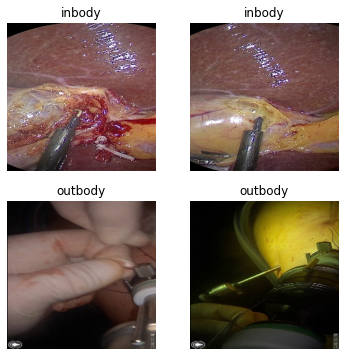

In [6]:
nrow, ncol = 2, 2
fig, axes = plt.subplots(nrow, ncol, figsize=(ncol * 3, nrow * 3), facecolor='white')
nexamples = nrow * ncol
samples = sorted(np.random.choice(len(check_val_dataset), size=nexamples, replace=False))
for sample, ax in zip(samples, axes.flatten()):
    _ds = check_val_dataset[sample]
    img, lbl = _ds["image"], _ds["label"]
    blended = img
    class_type = "outbody" if lbl else "inbody"
    blended = np.moveaxis(blended, 0, -1)  # RGB to end
    ax.imshow(blended)
    ax.set_title(f"{class_type}")
    ax.axis("off")

## Fine Tune

Do the typical fine-tuning process for 5 epochs based on the pre-trained `endoscopy_inbody_classification` bundle

2022-10-14 03:45:50,523 - INFO - --- input summary of monai.bundle.scripts.download ---
2022-10-14 03:45:50,523 - INFO - > name: 'endoscopic_inbody_classification'
2022-10-14 03:45:50,523 - INFO - > version: '0.2.0'
2022-10-14 03:45:50,524 - INFO - > bundle_dir: PosixPath('.')
2022-10-14 03:45:50,524 - INFO - > source: 'github'
2022-10-14 03:45:50,524 - INFO - > repo: 'Project-MONAI/model-zoo/hosting_storage_v1'
2022-10-14 03:45:50,524 - INFO - > progress: True
2022-10-14 03:45:50,524 - INFO - ---




endoscopic_inbody_classification_v0.2.0.zip: 185MB [03:02, 1.06MB/s]                                      


2022-10-14 03:48:53,588 - INFO - Downloaded: endoscopic_inbody_classification_v0.2.0.zip
2022-10-14 03:48:53,588 - INFO - Expected md5 is None, skip md5 check for file endoscopic_inbody_classification_v0.2.0.zip.
2022-10-14 03:48:53,589 - INFO - Writing into directory: ..


100%|███████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.32it/s]


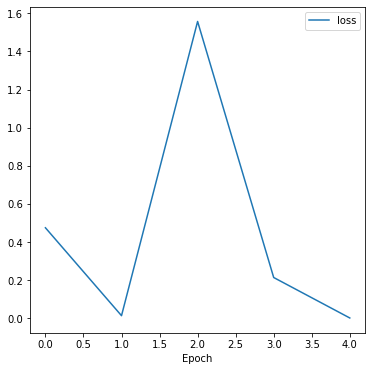

In [7]:
max_epochs = 5

pretrained_model = monai.bundle.load(
    name="endoscopic_inbody_classification", bundle_dir="./", version="0.2.0"
)

model.load_state_dict(pretrained_model)

model.train()
losses = []

for _ in trange(max_epochs):
    epoch_loss = 0
    for data in train_dataloader:
        inputs, labels = data["image"].to(device), data["label"].to(device)
        optimizer.zero_grad()
        predictions = model(inputs)
        loss_iter = loss(predictions, labels)
        loss_iter.backward()
        optimizer.step()
        epoch_loss += loss_iter.item()
    losses.append(epoch_loss/len(train_dataloader))

fig, ax = plt.subplots(1, 1, figsize=(6, 6), facecolor="white")
ax.set_xlabel("Epoch")
epochs = list(range(len(losses)))
ax.plot(epochs, losses, label="loss")
plt.legend()
plt.show()

## Inference
Do inference on the validation dataset to get the accuracy of the fine tuned model.

In [8]:
model.eval()
precision = Precision()
for data in val_dataloader:
    images, labels = data["image"].to(device), data["label"].to(device)
    predictions = model(images)
    labels = [post_label(x) for x in decollate_batch(labels)]
    predictions = [post_trans(x) for x in decollate_batch(predictions)]
    for label, pred in zip(labels, predictions):
        precision.update((pred, label))
print(f"The accuracy of classification model is {precision.compute().item()} after fine tune.")

The accuracy of classification model is 1.0 after fine tune.
